In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [ ]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

## CovariateShift

In [4]:
train['race']=pd.factorize(train['race'])[0]
test['race']=pd.factorize(test['race'])[0]

train = pd.get_dummies(train, columns=['race'])
test = pd.get_dummies(test, columns=['race'])

train.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)
test.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)


train.drop('religion', axis=1, inplace=True)
test.drop('religion', axis=1, inplace=True)

### Q_A

In [ ]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

### Q_A 1/5 count

In [ ]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A15'] = 0
train['Q_A3'] = 0

test['Q_A15'] = 0
test['Q_A3'] = 0

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1            

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1                        

### Q_E

In [ ]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

### tp

In [ ]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

In [ ]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 7:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 7:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

#### 극단값 중간값

In [ ]:
train['Q_A15tp17'] = train['Q_A15'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [ ]:
test['Q_A15tp17'] = test['Q_A15'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

## Target Encoding

### age_group

In [5]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [6]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [7]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [8]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [9]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [10]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### outlier

In [11]:
train = train[train.familysize < 25]

In [12]:
# age edu merried
train['Priority'] = 0
test['Priority'] = 0
train.loc[(train.age_group.isin(['+70s','60s'])), 'Priority'] = 7
train.loc[(train.age_group.isin(['50s','40s']) & (train.education==4) & (train.married==2)), 'Priority'] = 6
train.loc[(train.age_group.isin(['30s','20s']) & (train.education==3) & (train.married==3)), 'Priority'] = 5
train.loc[((train.education==0)), 'Priority'] = 4
train.loc[((train.education==2) & (train.married.isin([1,0]))), 'Priority'] = 3
train.loc[(train.age_group.isin(['10s']) & (train.education==1)), 'Priority'] = 1

In [ ]:
train.shape, train.columns

In [ ]:
test.shape, test.columns

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [13]:
#col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat = ['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
# 'race_0',
 #'religion',
 'urban'
,'Priority'
          ]

In [14]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          , categorical_features=col_cat
          , numeric_features = ['race_0']#,'tp17','tp4','Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          #, ignore_features =['Priority']#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 78)"
4,Missing Values,False
5,Numeric Features,22
6,Categorical Features,55
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 30.6 s


In [15]:
best_5 = compare_models(sort = 'AUC', n_select = 5
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6938,0.7641,0.6491,0.7565,0.6987,0.3911,0.3959,19.9843
1,CatBoost Classifier,0.6905,0.7621,0.6536,0.7485,0.6978,0.3836,0.3873,18.2545
2,Light Gradient Boosting Machine,0.6903,0.7609,0.6486,0.7510,0.6961,0.3837,0.3880,1.0167
3,Linear Discriminant Analysis,0.6866,0.7581,0.6553,0.7416,0.6957,0.3752,0.3783,1.0363
4,Extra Trees Classifier,0.6884,0.7579,0.6311,0.7585,0.6889,0.3820,0.3885,2.7545
5,Ada Boost Classifier,0.6840,0.7538,0.6547,0.7380,0.6938,0.3698,0.3727,4.9195
6,Extreme Gradient Boosting,0.6691,0.7394,0.6661,0.7107,0.6876,0.3368,0.3376,11.2904
7,Random Forest Classifier,0.6548,0.7123,0.5939,0.7252,0.6529,0.3164,0.3227,0.3322


In [16]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6930,0.7647,0.6545,0.7519,0.6998,0.3887,0.3926
1,0.7021,0.7698,0.6643,0.7607,0.7093,0.4067,0.4106
2,0.6945,0.7679,0.6437,0.7607,0.6973,0.3932,0.3988
3,0.6904,0.7631,0.6511,0.7498,0.6969,0.3838,0.3878
4,0.6933,0.7690,0.6449,0.7581,0.6969,0.3907,0.3959
Mean,0.6947,0.7669,0.6517,0.7562,0.7001,0.3926,0.3971
SD,0.0039,0.0025,0.0075,0.0045,0.0047,0.0077,0.0077


In [17]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6944,0.764,0.6524,0.7553,0.7001,0.3919,0.3962


In [18]:
%%time
final_model = finalize_model(blended)

Wall time: 9min 10s


In [19]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [20]:
submission['voted'] = predictions['Score']

# 5. 제출

In [21]:
submission.to_csv('output/20201010-1.csv')

In [22]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7064,0.7724,0.6590,0.7709,0.7106,0.4164,0.4216
1,0.6844,0.7484,0.6492,0.7416,0.6923,0.3714,0.3749
2,0.6876,0.7628,0.6492,0.7465,0.6944,0.3780,0.3819
3,0.7073,0.7739,0.6590,0.7723,0.7112,0.4183,0.4237
4,0.7001,0.7736,0.6574,0.7616,0.7057,0.4034,0.4079
5,0.6835,0.7600,0.6377,0.7466,0.6879,0.3710,0.3757
6,0.6928,0.7660,0.6426,0.7590,0.6960,0.3899,0.3954
7,0.6870,0.7566,0.6497,0.7451,0.6941,0.3767,0.3804
8,0.7018,0.7740,0.6497,0.7689,0.7043,0.4078,0.4137
9,0.6870,0.7539,0.6374,0.7522,0.6901,0.3783,0.3836


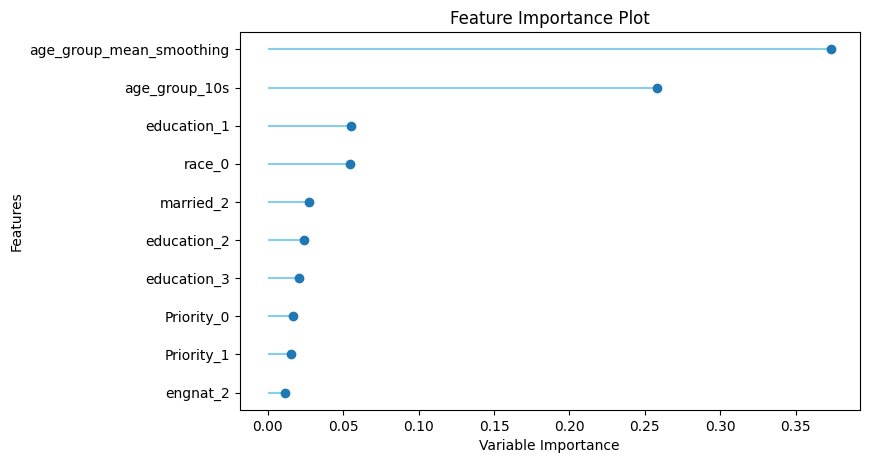

In [23]:
plot_model(estimator = gbc, plot = 'feature')

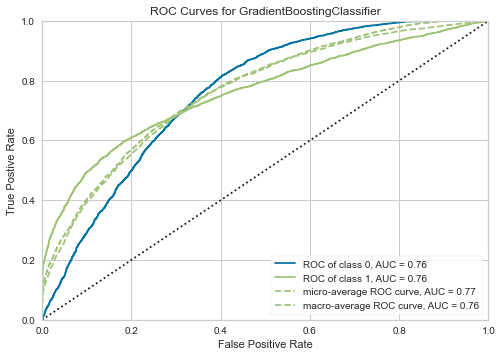

In [24]:
plot_model(estimator = gbc, plot = 'auc')

In [25]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6961,0.7664,0.6557,0.7561,0.7024,0.3951,0.3993
1,0.6876,0.7541,0.6492,0.7465,0.6944,0.3780,0.3819
2,0.6827,0.7595,0.6443,0.7415,0.6895,0.3683,0.3721
3,0.7019,0.7671,0.6598,0.7630,0.7077,0.4069,0.4113
4,0.6934,0.7700,0.6492,0.7557,0.6984,0.3903,0.3949
5,0.6898,0.7578,0.6467,0.7514,0.6952,0.3830,0.3875
6,0.6879,0.7572,0.6377,0.7539,0.6909,0.3801,0.3856
7,0.6812,0.7479,0.6481,0.7369,0.6897,0.3646,0.3678
8,0.6919,0.7718,0.6473,0.7543,0.6967,0.3874,0.3921
9,0.6901,0.7570,0.6481,0.7510,0.6957,0.3835,0.3878


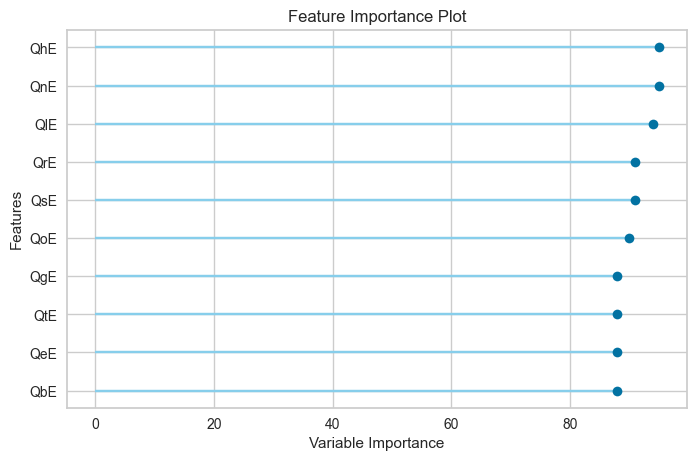

In [26]:
plot_model(estimator = lightgbm, plot = 'feature')